In [1]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
(train_X, train_y), (test_X, test_y) = load_data()

In [3]:
print(train_X.shape)
print(test_X.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


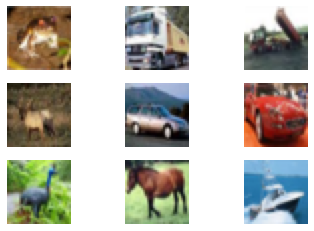

In [4]:
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.axis('off')
  plt.imshow(train_X[i])

plt.show()


# How to Define and Train the Discriminator Model

In [5]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

def define_discriminator(in_shape=(32,32,3)):
  # define model
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same',input_shape = in_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))

  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model

In [6]:
model = define_discriminator()

In [7]:
# summary model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       65664     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       1

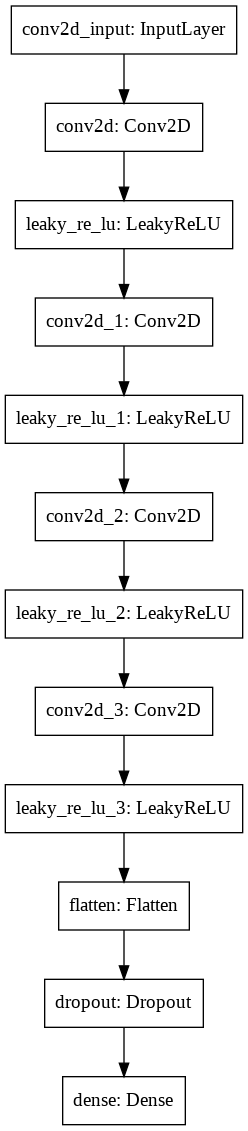

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model)

## Test Discriminator

In [9]:
def load_real_samples():
  (train_x, _), (_, _) = load_data()
  X = train_X.astype('float32')
  X =  (X - 127.5) / 127.5
  return X

`generate_real_samples()`

1.   select a random subsample of images (x)
2.   set class labels for sample (y)
3.   return x, y



In [10]:
# discriminator needs label and data
# 1 is real 0 is fake
def generate_real_samples(dataset, n_sample):
  i = np.random.randint(0, dataset.shape[0], n_sample)
  X = dataset[i]
  # it's real data so label 1
  y = np.ones((n_sample, 1))

  return X, y


We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1], then scaled to the range [-1, 1] like our scaled real images.

In [11]:
def generate_fake_samples(n_sample):
  X = np.random.rand(32 * 32 * 3, n_sample)
  X = -1 + X * 2
  X = X.reshape((n_sample, 32, 32, 3))
  y = np.zeros((n_sample, 1))

  return X, y

In [12]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  # two data sources, in each epoch use half real and half fake data
  half_batch = int(n_batch / 2)
  for i in range(n_iter):
    # load read sample and train model with them
    X_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(X_real, y_real)

    # generate fake sample and train model with them
    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)



    print(" itr : {} ----- real_acc : {} ------ fake_acc : {}".format(i+1, real_acc * 100, fake_acc * 100))

In [13]:
# create and test discriminator model
model = define_discriminator()
dataset = load_real_samples()

train_discriminator(model, dataset)

 itr : 1 ----- real_acc : 37.5 ------ fake_acc : 0.0
 itr : 2 ----- real_acc : 100.0 ------ fake_acc : 0.0
 itr : 3 ----- real_acc : 98.4375 ------ fake_acc : 48.4375
 itr : 4 ----- real_acc : 95.3125 ------ fake_acc : 100.0
 itr : 5 ----- real_acc : 95.3125 ------ fake_acc : 100.0
 itr : 6 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 7 ----- real_acc : 96.875 ------ fake_acc : 100.0
 itr : 8 ----- real_acc : 96.875 ------ fake_acc : 100.0
 itr : 9 ----- real_acc : 98.4375 ------ fake_acc : 100.0
 itr : 10 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 11 ----- real_acc : 98.4375 ------ fake_acc : 100.0
 itr : 12 ----- real_acc : 98.4375 ------ fake_acc : 100.0
 itr : 13 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 14 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 15 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 16 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 17 ----- real_acc : 100.0 ------ fake_acc : 100.0
 itr : 18 ----- real_acc : 10

# How to Define and Use the Generator Model

In [14]:
from keras.layers import Conv2DTranspose
from keras.layers import Reshape

In [15]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))

  #upsample
  # 8 x 8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), activation='relu',padding = 'same'))
  # 16 x 16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), activation='relu',padding = 'same'))
  # 32 x 32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), activation='relu',padding = 'same'))

  model.add(Conv2D(3, (3,3), activation='relu', padding = 'same'))


  return model


In [16]:
latent_dim = 100
model = define_generator(latent_dim)

In [17]:
# summary model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 3)        

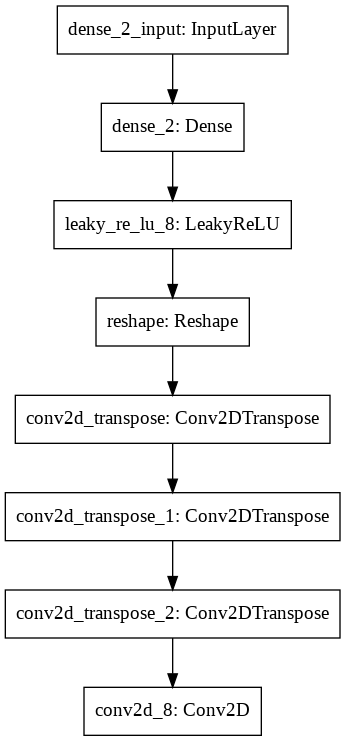

In [18]:
# plot model
plot_model(model)

`generate_latent_points()`

generates the desired number of points in the latent space that can be used as input to the generator model

In [19]:
# generates input of generator which is random noise
def generate_latent_points(latent_dim, n_samples):
  X_input = np.random.rand(latent_dim * n_samples) 
  X_input = X_input.reshape(n_samples, latent_dim)
  return X_input

In [20]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(X_input)
  y = np.zeros((n_samples, 1))

  return X, y

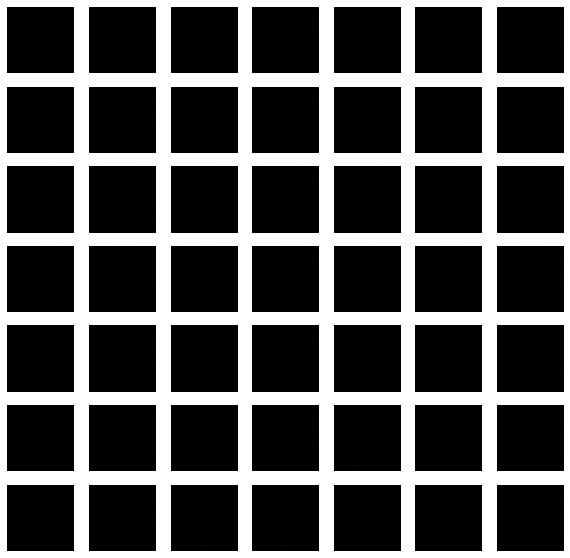

In [21]:
# create and test generator model

latent_dim = 100
model = define_generator(latent_dim)
n_samples = 49

X, _ = generate_fake_samples(model, latent_dim, n_samples)

plt.figure(figsize=(10, 10))
for i in range(n_samples):
  plt.subplot(7, 7, i+1)
  plt.axis('off')
  plt.imshow(X[i])

plt.show()

# How to Train the Generator Model

In [22]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = Sequential()
  # add g_model and d_model to model
  model.add(g_model)
  model.add(d_model)

  # compile 
  opt = Adam(lr = 0.0002, beta_1=0.5)
  model.compile(loss = 'binary_crossentropy', optimizer= opt)
  
  return model

In [23]:
# create gan_model 
latent_dim = 100

d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

In [24]:
# summary gan_model
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 493825    
Total params: 1,959,940
Trainable params: 1,466,115
Non-trainable params: 493,825
_________________________________________________________________


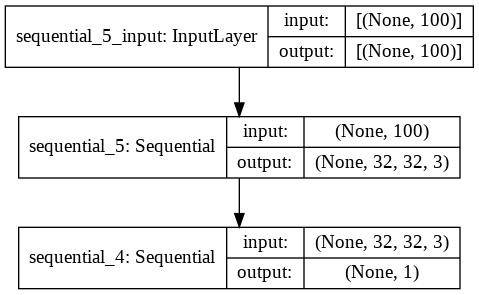

In [25]:
# plot gan_model
plot_model(gan_model, show_shapes=True)

In [26]:
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
  for i in range(n_epochs):
    X_gan = generate_latent_points(latent_dim, n_batch)
    y_gan = np.ones((n_batch, 1))
    gan_model.train_on_batch(X_gan, y_gan)

In [27]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      # discriminator
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

      # this should not be half
      X_gan = generate_latent_points(latent_dim, n_batch)
      # Adverserial lie
      y_gan = np.ones((n_batch, 1))
      g_loss, _ = gan_model.train_on_batch(X_gan, y_gan)

      print("{} -- {}/{} -- {} -- {} -- {}".format(i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))

# How to Evaluate GAN Model Performance

In [28]:
def save_plot(examples, epoch, n=7):
  plt.figure(figsize=(20, 20))
  examples = (examples + 1) / 2.0
  for i in range(n*n):
    plt.subplot(n, n, 1+i)
    plt.axis('off')
    plt.imshow(examples[i])

  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [29]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):

  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

  X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
  
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  save_plot(X_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [30]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      # discriminator
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

      # this should not be half
      X_gan = generate_latent_points(latent_dim, n_batch)
      # Adverserial lie
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

  
      print("{} -- {}/{} -- {} -- {} -- {}".format(i+1, j+1, batch_per_epoch, d_loss_real, d_loss_fake, g_loss))
  
      if ((i+1) %10 == 0) and ( j == batch_per_epoch - 2):
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [31]:
# create models 
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

In [ ]:
# train
train(g_model, d_model, gan_model, dataset, latent_dim)